In [24]:
# Step 1: Import Necessary Libraries
import os
import pandas as pd
import numpy as np
import PyPDF2
import re
import nltk
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

In [25]:
# Step 2: Initialize Dask Client
cluster = LocalCluster(n_workers=6, threads_per_worker=2, memory_limit="7.5GB")
client = Client(cluster)

c:\Users\srikanth.p.lv\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52790 instead
  warnings.warn(
c:\Users\srikanth.p.lv\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.35s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


In [26]:
# Step 3: Download NLTK Data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srikanth.p.lv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\srikanth.p.lv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# Step 4: Load Training Labels
train_csv_file_path = 'train_160.csv'
train_labels_df = pd.read_csv(train_csv_file_path)

In [28]:
# Step 5: Define Function to Extract Text from PDF
def extract_text_from_pdf(pdf_path):
    text = ""
    try:
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page in pdf_reader.pages:
                text += page.extract_text() if page.extract_text() else ""
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text if text.strip() else "MISSING_TEXT"

In [29]:
# Step 6: Extract Text and Create DataFrame
train_pdf_folder_path = r'train_80_both'
train_data = []

for _, row in train_labels_df.iterrows():
    file_name = row['File Name']
    label = row['Label']
    pdf_path = os.path.join(train_pdf_folder_path, file_name)
    text = extract_text_from_pdf(pdf_path)
    train_data.append({'text': text, 'label': label})

train_df = pd.DataFrame(train_data)

ignore '/Perms' verify failed
c:\Users\srikanth.p.lv\AppData\Local\Programs\Python\Python312\Lib\site-packages\PyPDF2\_cmap.py:134: PdfReadWarning: Advanced encoding /Identity#2DH not implemented yet
  warnings.warn(
c:\Users\srikanth.p.lv\AppData\Local\Programs\Python\Python312\Lib\site-packages\PyPDF2\_cmap.py:134: PdfReadWarning: Advanced encoding /UniKS-UTF16-H not implemented yet
  warnings.warn(


In [30]:
print(train_df.head())

                                                text   label
0  INTEGRATED \nANNUAL \nREPORT \n2022 GRI 2-3\nM...  annual
1  INTEGRATED REPORT\n \n2023 \nPromotion Structu...  annual
2   \n1  \n \n \n \nAAM Reports Fourth  Quarter a...  annual
3  2023 Annual ReportTO OUR SHAREHOLDERSEvery yea...  annual
4  Table of Contents\nManagement report Page\nInt...  annual


In [31]:
# Step 7: Preprocess Text
def preprocess_text(text):
    if not isinstance(text, str):  # Check if the input is not a string
        return []  # Return an empty list for invalid inputs
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = text.split()  # Tokenize text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens
    return tokens

In [32]:
# Step 8: Apply Preprocessing with Dask
# Ensure no NaN values in the 'text' column
train_df['text'] = train_df['text'].fillna("")

# Create a Dask DataFrame
dask_df = dd.from_pandas(train_df, npartitions=4)

# Apply preprocessing in parallel
dask_df['cleaned_text'] = dask_df['text'].map(preprocess_text)

# Compute the cleaned DataFrame
train_df = dask_df.compute()


c:\Users\srikanth.p.lv\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask_expr\_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('text', 'object'))

  warnings.warn(meta_warning(meta))
c:\Users\srikanth.p.lv\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 47.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [33]:
# Step 10: Train Word2Vec Model
sentences = train_df['cleaned_text'].tolist()
word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)


In [34]:
# Step 11: Create Document Vectors
def document_vector(tokens):
    tokens = [word for word in tokens if word in word2vec_model.wv.key_to_index]
    if not tokens:  # If no tokens remain, return a zero vector
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model.wv[tokens], axis=0)

# Apply document vectorization with Dask
dask_df['doc_vector'] = dask_df['cleaned_text'].map_partitions(
    lambda part: part.apply(document_vector)
)
train_df = dask_df.compute()

c:\Users\srikanth.p.lv\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 169.83 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [35]:
# Step 12: Create Feature Matrix and Encode Labels
X = np.vstack(train_df['doc_vector'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['label'])

In [36]:
# Step 13: Load and Process Testing Data
test_csv_file_path = 'test_50.csv'
test_labels_df = pd.read_csv(test_csv_file_path)
test_pdf_folder_path = r'test_25_both'
test_data = []

for _, row in test_labels_df.iterrows():
    file_name = row['File Name']
    label = row['Label']
    pdf_path = os.path.join(test_pdf_folder_path, file_name)
    text = extract_text_from_pdf(pdf_path)
    test_data.append({'text': text, 'label': label})

test_df = pd.DataFrame(test_data)

# Preprocess and compute testing data
dask_test_df = dd.from_pandas(test_df, npartitions=4)
dask_test_df['cleaned_text'] = dask_test_df['text'].map(preprocess_text)
test_df = dask_test_df.compute()

# Create feature matrix for testing data
X_test = np.vstack([document_vector(tokens) for tokens in test_df['cleaned_text']])
y_test = label_encoder.transform(test_df['label'])

Error reading test_25_both\HYUNDAI WIA MEXICO S DE RL DE CV_annual report_2023.pdf: trailer can not be read ()


c:\Users\srikanth.p.lv\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask_expr\_collection.py:4196: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('text', 'object'))

  warnings.warn(meta_warning(meta))
c:\Users\srikanth.p.lv\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 16.72 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [37]:
# Step 14: Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=4, random_state=42)
rf_model.fit(X, y)


RandomForestClassifier(max_depth=4, n_estimators=1000, random_state=42)

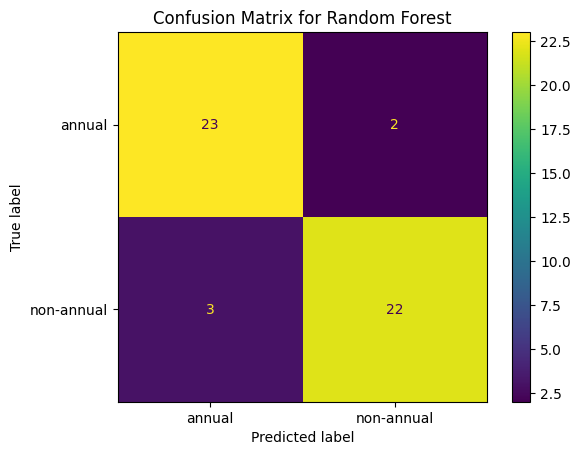

Classification Report for Random Forest:
              precision    recall  f1-score   support

      annual       0.88      0.92      0.90        25
  non-annual       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50



In [38]:
# Step 15: Predict and Evaluate with Random Forest
y_pred_rf = rf_model.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=label_encoder.classes_).plot()
plt.title("Confusion Matrix for Random Forest")
plt.show()

print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


In [39]:
import pickle

# Step 16: Save the Random Forest Model to a Pickle File
pickle_file_path = "random_forest_model.pkl"

with open(pickle_file_path, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"Model saved as {pickle_file_path}")

Model saved as random_forest_model.pkl


In [40]:
# Step 17: Load the Random Forest Model from the Pickle File
with open(pickle_file_path, 'rb') as file:
    loaded_rf_model = pickle.load(file)

# Verify the model
print("Loaded Random Forest Model:", loaded_rf_model)

Loaded Random Forest Model: RandomForestClassifier(max_depth=4, n_estimators=1000, random_state=42)


In [41]:
# Use the loaded model to predict
y_pred_loaded_rf = loaded_rf_model.predict(X_test)

# Evaluate the loaded model
print("Classification Report for Loaded Model:")
print(classification_report(y_test, y_pred_loaded_rf, target_names=label_encoder.classes_))

Classification Report for Loaded Model:
              precision    recall  f1-score   support

      annual       0.88      0.92      0.90        25
  non-annual       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50



In [43]:
# Save the Word2Vec model
word2vec_model.save("word2vec_model.model")
print("Word2Vec model saved successfully!")

Word2Vec model saved successfully!
